🔄 Loading model...
✅ Model loaded: models\vgg_model.h5
Total kelas: 70
✅ MTCNN initialized

🔍 Starting inference on Test/ ...

⚠ No face detected: Test\Intan Permata Sari\IMG_20240410_112254_085 - Intan Permata Sari.jpg
⚠ Cannot read: Test\Lois Novel E Gurning\foto 3 - LOIS NOVEL E. GURNING.png
⚠ Cannot read: Test\Lois Novel E Gurning\foto 4 - LOIS NOVEL E. GURNING.png
⚠ Cannot read: Test\Martua Kevin A.M.H.Lubis\IMG_20241208_223409_653 - MARTUA KEVIN ANDREAS MUAL H LUBIS.jpg
⚠ No face detected: Test\Muhammad Nelwan Fakhri\20251124_183233 - Muhammad Nelwan Fakhri.jpg

================ SUMMARY ================
Total image found in Test/: 284
Used for evaluation       : 279
Skipped (no face/error)   : 5

✅ CSV saved: vgg_inference_results.csv
📊 EVALUATION METRICS

🔹 Accuracy : 99.28%

🔹 Classification Report:

                                 precision    recall  f1-score   support

           Abraham Ganda Napitu       1.00      1.00      1.00         4
       Abu Bakar Siddiq Siregar  

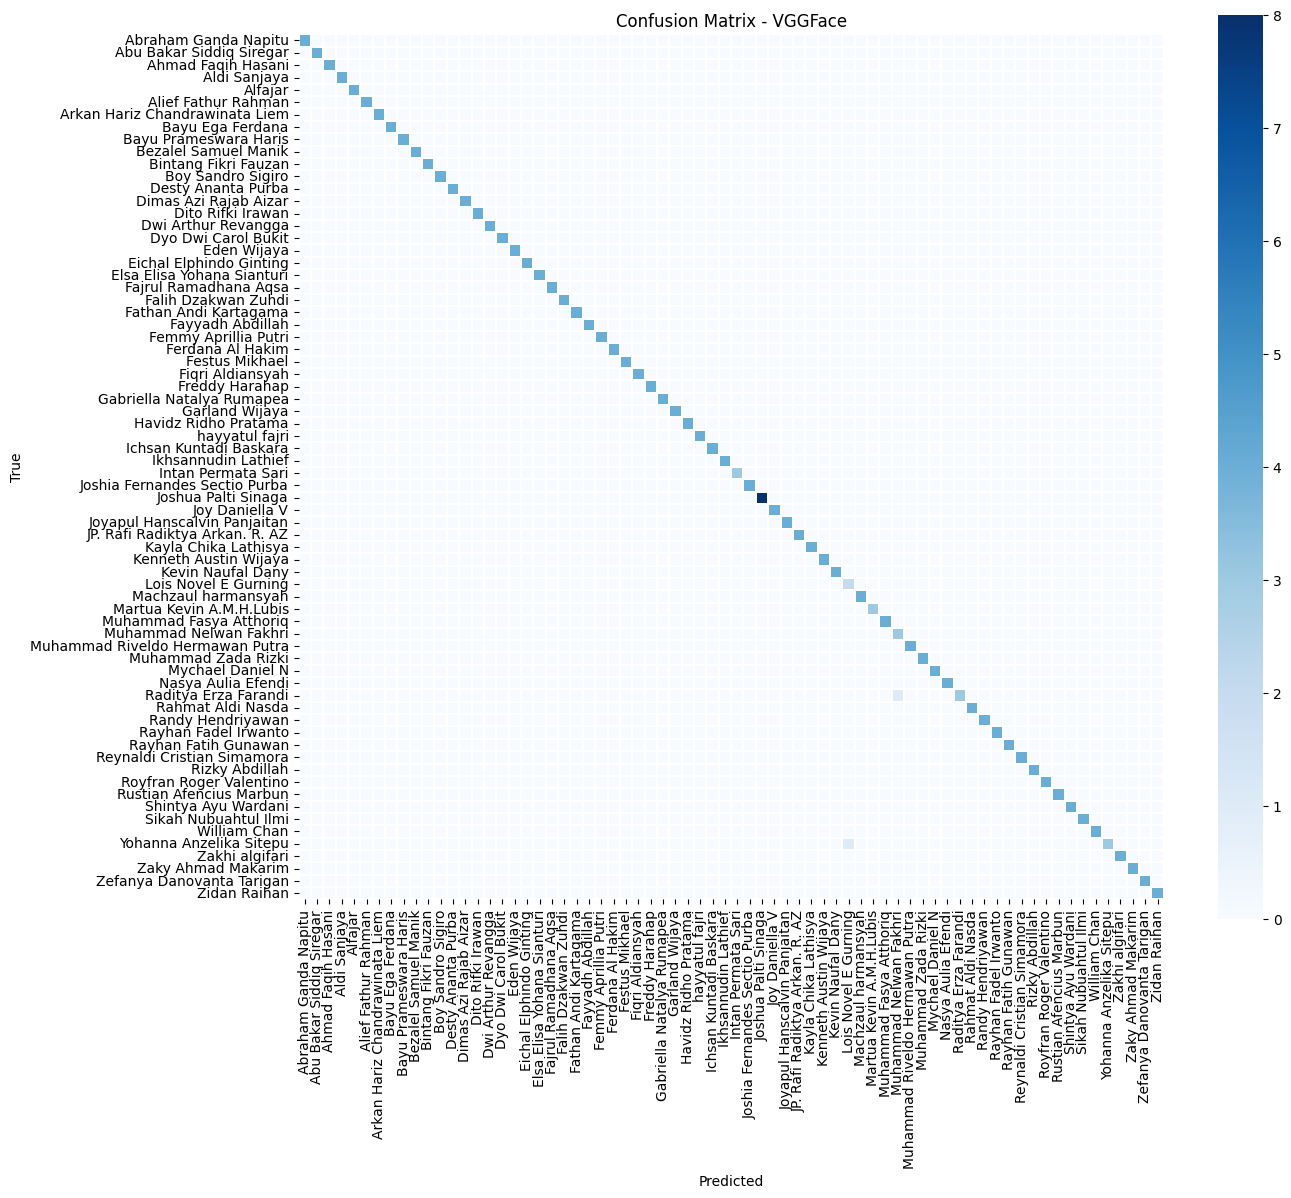

In [14]:
import os
from pathlib import Path

import numpy as np
import cv2
import pandas as pd

from mtcnn import MTCNN
from keras_vggface.utils import preprocess_input
from tensorflow.keras.models import load_model

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score
)

import warnings
warnings.filterwarnings("ignore")

# ============================
# PATH KONFIG
# ============================
MODEL_DIR = Path("./models")
TEST_DIR  = Path("./Test")   # <-- kamu pakai Test dari Train

MODEL_PATH = MODEL_DIR / "vgg_model.h5"
CLASS_NAMES_PATH = MODEL_DIR / "class_names.npy"

IMAGE_SIZE = 224
PREPROCESS_VERSION = 2
THRESHOLD_UNKNOWN = 0.5

# ============================
# LOAD MODEL & LABEL
# ============================
print("🔄 Loading model...")

model_vgg = load_model(MODEL_PATH, compile=False)
class_names = np.load(CLASS_NAMES_PATH, allow_pickle=True).tolist()

name_to_idx = {name: i for i, name in enumerate(class_names)}

print(f"✅ Model loaded: {MODEL_PATH}")
print(f"Total kelas: {len(class_names)}")

# ============================
# INIT MTCNN
# ============================
detector = MTCNN()
print("✅ MTCNN initialized")

# ============================================================
# FUNGSI DETEKSI + PREPROCESS (ANTI MEMORY ERROR)
# ============================================================

def safe_resize(img, max_side):
    """Resize gambar besar sebelum MTCNN, untuk hindari MemoryError."""
    h, w = img.shape[:2]
    if max(h, w) <= max_side:
        return img

    scale = max_side / max(h, w)
    new_w = int(w * scale)
    new_h = int(h * scale)
    return cv2.resize(img, (new_w, new_h))


def detect_and_preprocess_face(img_bgr,
                               image_size=IMAGE_SIZE,
                               preprocess_version=PREPROCESS_VERSION):
    """
    DETEKSI WAJAH AMAN UNTUK GAMBAR BESAR
    Ada 2 tahap resize:
    1. Resize ke 1024 → proses MTCNN
    2. Jika masih gagal → resize ke 720 → proses lagi
    """

    # --- Tahap 1: resize 1024 px
    img_small = safe_resize(img_bgr, 1024)
    img_rgb = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)

    try:
        faces = detector.detect_faces(img_rgb)
    except MemoryError:
        print("💥 MemoryError @1024px → fallback to 720px")
        img_small = safe_resize(img_bgr, 720)
        img_rgb = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)
        try:
            faces = detector.detect_faces(img_rgb)
        except Exception:
            return None, None

    if len(faces) == 0:
        return None, None

    # --- Ambil wajah terbesar
    faces = sorted(faces, key=lambda x: x["box"][2] * x["box"][3], reverse=True)
    x, y, w, h = faces[0]["box"]
    x, y = abs(x), abs(y)
    x2 = x + w
    y2 = y + h

    face = img_rgb[y:y2, x:x2]
    if face.size == 0:
        return None, None

    # Resize wajah ke input model
    face_resized = cv2.resize(face, (image_size, image_size)).astype("float32")

    face_pp = preprocess_input(face_resized.copy(), version=preprocess_version)
    face_pp = np.expand_dims(face_pp, axis=0)

    return face_pp, face_resized


# ============================================================
# LOOP TESTSET BESAR
# ============================================================

y_true = []
y_pred = []
y_conf = []
filepaths = []
true_names = []
pred_names = []

n_images_total = 0
n_skipped = 0

print("\n🔍 Starting inference on Test/ ...\n")

for class_dir in sorted(TEST_DIR.iterdir()):
    if not class_dir.is_dir():
        continue

    class_name = class_dir.name
    if class_name not in name_to_idx:
        print(f"⚠ WARNING: {class_name} tidak ada di class_names. SKIP.")
        continue

    true_idx = name_to_idx[class_name]

    for img_path in class_dir.iterdir():
        if not img_path.is_file():
            continue
        if img_path.suffix.lower() not in [".jpg", ".jpeg", ".png", ".bmp"]:
            continue

        n_images_total += 1

        img = cv2.imread(str(img_path))
        if img is None:
            print(f"⚠ Cannot read: {img_path}")
            n_skipped += 1
            continue

        # DETEKSI AMAN
        face_pp, face_vis = detect_and_preprocess_face(img)
        if face_pp is None:
            print(f"⚠ No face detected: {img_path}")
            n_skipped += 1
            continue

        # PREDIKSI
        preds = model_vgg.predict(face_pp, verbose=0)[0]
        pred_idx = int(np.argmax(preds))
        conf = float(preds[pred_idx])
        pred_name = class_names[pred_idx]

        # SIMPAN
        y_true.append(true_idx)
        y_pred.append(pred_idx)
        y_conf.append(conf)
        filepaths.append(str(img_path))
        true_names.append(class_name)
        pred_names.append(pred_name)


print("\n================ SUMMARY ================")
print(f"Total image found in Test/: {n_images_total}")
print(f"Used for evaluation       : {len(y_true)}")
print(f"Skipped (no face/error)   : {n_skipped}")
print("=========================================\n")


# ============================================================
# SIMPAN CSV DETAIL
# ============================================================

results_df = pd.DataFrame({
    "filepath": filepaths,
    "true_name": true_names,
    "true_label": y_true,
    "pred_name": pred_names,
    "pred_label": y_pred,
    "confidence": y_conf
})

csv_path = "vgg_inference_results.csv"
results_df.to_csv(csv_path, index=False)

print(f"✅ CSV saved: {csv_path}")
results_df.head()


# ============================================================
# METRIKS GLOBAL
# ============================================================

if len(y_true) == 0:
    print("❌ Tidak ada sampel valid.")
else:
    print("📊 EVALUATION METRICS\n")

    print(f"🔹 Accuracy : {accuracy_score(y_true, y_pred)*100:.2f}%\n")

    print("🔹 Classification Report:\n")
    print(
        classification_report(
            y_true,
            y_pred,
            target_names=class_names,
            zero_division=0
        )
    )

    cm = confusion_matrix(y_true, y_pred)
    print(f"Confusion matrix shape: {cm.shape}")

    # plot
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(14, 12))
    sns.heatmap(
        cm,
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
        square=True,
        cbar=True,
        linewidths=0.3
    )
    plt.title("Confusion Matrix - VGGFace")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()